# **Setup**

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot as plt
from sklearn.svm import OneClassSVM

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

from sklearn.metrics import plot_roc_curve
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit

import pandas as pd
import numpy as np

In [67]:
df = pd.read_csv('preprocessed_spam_ham_phishing.csv')

**Remove phishing emails, only consider ham and spam:**

In [68]:
df = df[df['label'] != 2]
print(df.shape)

(75419, 95)


In [69]:
df['label'].value_counts()

1    50199
0    25220
Name: label, dtype: int64

In [70]:
df_ham = df[df['label'] == 0]
df_spam = df[df['label'] == 1]
print(df_ham.shape)
print(df_spam.shape)

(25220, 95)
(50199, 95)


In [71]:
df_ham_Y = df_ham['label']
df_ham_X = df_ham.drop('label', axis=1)

**Take 50% of the ham emails to be used for training:**

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test_ham, y_train, y_test_ham = train_test_split(df_ham_X, df_ham_Y, test_size=0.50, random_state=42)

In [73]:
print(X_train.shape)
print(X_test_ham.shape)
print(y_test_ham.shape)

(12610, 94)
(12610, 94)
(12610,)


**Get the test set of spam emails, which contains the same number of emails as ham test (12,610):**

In [74]:
df_spam_Y = df_spam['label']
df_spam_X = df_spam.drop('label', axis=1)

In [75]:
print(df_spam_Y.shape)
print(df_spam_X.shape)

(50199,)
(50199, 94)


In [76]:
_, X_test_spam, _, y_test_spam = train_test_split(df_spam_X, df_spam_Y, test_size=12610, random_state=42)

In [77]:
print(X_test_spam.shape)
print(y_test_spam.shape)

(12610, 94)
(12610,)


**Combine the test set of spam and ham emails into one:**

In [78]:
test_X = X_test_ham.append(X_test_spam, ignore_index=True)
test_Y = y_test_ham.append(y_test_spam, ignore_index=True)

In [79]:
print(test_X.shape)
print(test_Y.shape)

(25220, 94)
(25220,)


In [80]:
features_list = test_X.columns

**OC-SVM predicts either 1 or -1, so need to adjust labels:**

In [81]:
test_Y = pd.DataFrame(test_Y, columns=['label'])
test_Y.loc[test_Y['label'] == 1, 'label'] = -1
test_Y.loc[test_Y['label'] == 0, 'label'] = 1

In [82]:
test_Y.value_counts()

label
 1       12610
-1       12610
dtype: int64

**Apply a standard scaler to the full data set:**

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(test_X)
test_X = scaler.transform(test_X)
test_X = pd.DataFrame(test_X, columns=features_list)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns=features_list)

# **Feature Selection:**

In [84]:
feature_list = test_X.columns

Top features sorted:
Feature: lines, Score: 0.012728
Feature: content-length, Score: 0.012490
Feature: domain_match_errors-to_sender, Score: 0.006305
Feature: str_precedence_list, Score: 0.005948
Feature: span_time, Score: 0.005829
Feature: str_return-path_bounce, Score: 0.005630
Feature: hops, Score: 0.005234
Feature: missing_list-subscribe, Score: 0.005075
Feature: missing_list-post, Score: 0.005075
Feature: missing_list-id, Score: 0.005075
Feature: missing_list-help, Score: 0.005075
Feature: domain_match_to_received, Score: 0.004798
Feature: missing_precedence, Score: 0.004718
Feature: missing_list-unsubscribe, Score: 0.004718
Feature: missing_received-spf, Score: 0.003767
Feature: missing_x-spam-check-by, Score: 0.003688
Feature: missing_mailing-list, Score: 0.003688
Feature: domain_match_from_return-path, Score: 0.003172
Feature: number_replies, Score: 0.002538
Feature: missing_x-mailing-list, Score: 0.002339
Feature: missing_references, Score: 0.002300
Feature: day_of_week, Score

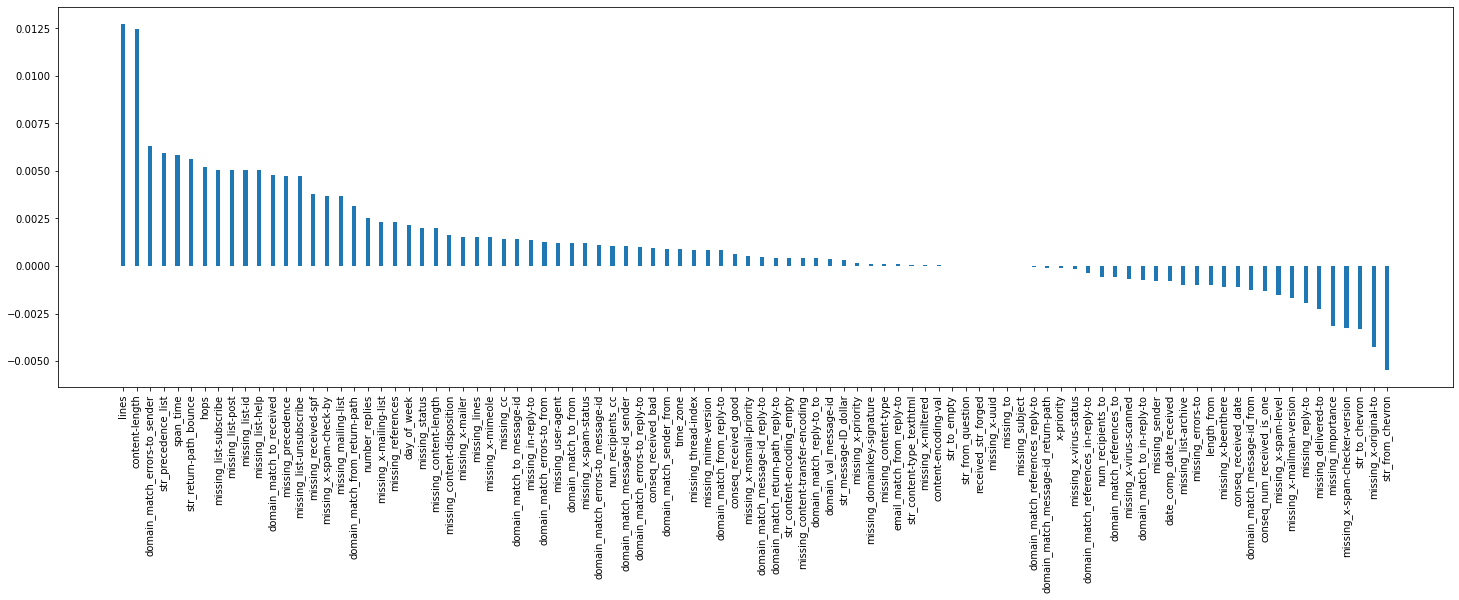

In [18]:
model = OneClassSVM(kernel='poly', degree=6)
model.fit(X_train)

results = permutation_importance(model, X_train, y_train, 
                                 scoring='accuracy', n_repeats=2, n_jobs=-1)
importance = results.importances_mean

fig = plt.figure(figsize =(25, 7))

importances_sorted = sorted(zip(importance, feature_list), reverse=True)
feature_sorted, importance_sorted = zip(*importances_sorted)

perm_svm_feature_importances = importance_sorted

print("Top features sorted:")
for x, imp in zip(feature_sorted, importance_sorted):
  print('Feature: %s, Score: %f' % (imp, x))

for x, imp in zip(feature_sorted, importance_sorted):
  print('\'' + imp + '\',')

plt.xticks(rotation='vertical')
plt.bar([x for x in importance_sorted], feature_sorted, width=0.3)
plt.show()

**Reduce the features:**

In [85]:
new_feature_list = [
'lines',
'content-length',
'domain_match_errors-to_sender',
'missing_list-subscribe',
'str_precedence_list',
'missing_list-post',
'missing_list-id',
'missing_list-help',
'missing_received-spf',
'domain_match_to_received',
'missing_x-spam-check-by',
'missing_precedence',
'missing_mailing-list',
'str_return-path_bounce',
'missing_list-unsubscribe',
'day_of_week',
'missing_x-mailing-list',
'hops',
'missing_status',
'missing_content-length',
'domain_match_from_return-path',
'missing_references',
'missing_lines',
'number_replies',
'missing_cc',
'missing_in-reply-to',
'time_zone',
'span_time',
'missing_x-spam-status',
'missing_content-disposition',
'missing_x-mimeole',
'missing_thread-index',
'missing_x-mailer',
'domain_match_to_message-id',
'conseq_received_bad',
'missing_user-agent',
'domain_match_from_reply-to',
'domain_match_errors-to_from',
'domain_match_return-path_reply-to',
'domain_match_message-id_reply-to',
'missing_errors-to',
'missing_sender',
'domain_match_errors-to_message-id',
'domain_match_to_from',
'domain_match_errors-to_reply-to',
'domain_match_message-id_sender',
'missing_mime-version',
'missing_list-archive',
'conseq_received_good',
'str_message-ID_dollar',
'domain_val_message-id',
'num_recipients_to',
'missing_x-beenthere',
'num_recipients_cc',
'domain_match_sender_from',
'missing_x-msmail-priority',
'str_content-type_texthtml',
'str_content-encoding_empty',
'missing_content-transfer-encoding',
'missing_content-type',
'email_match_from_reply-to'
]

test_X = test_X[new_feature_list]
X_train = X_train[new_feature_list]

In [86]:
print(test_X.shape)
print(X_train.shape)

(25220, 61)
(12610, 61)


# **Testing:**

**OC-SVM:**

In [93]:
%%time

ocsvm = OneClassSVM(kernel='poly', degree=6, nu=0.2)
ocsvm.fit(X_train)

# Test the model on the test set
predictions = ocsvm.predict(test_X)

# Get the evaluation metrics
print('Accuracy:', accuracy_score(test_Y, predictions)*100)
print('F1 Score:', f1_score(test_Y, predictions)*100)
print('Recall:', recall_score(test_Y, predictions)*100)
print('Precision:', precision_score(test_Y, predictions)*100)
print('ROC AUC:', roc_auc_score(test_Y, predictions)*100)
print('Confusion Matrix:', confusion_matrix(test_Y, predictions))

Accuracy: 89.33386201427439
F1 Score: 88.24300699300699
Recall: 80.05551149881047
Precision: 98.29600778967867
ROC AUC: 89.33386201427439
Confusion Matrix: [[12435   175]
 [ 2515 10095]]
Wall time: 9.93 s
